In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import platform
import sys

sys.path.append('/Users/joewandy/work/git/vimms')
sys.path.append('/Users/joewa/work/git/vimms')
sys.path.append('/home/joewandy/vimms')

In [3]:
from os.path import exists
import socket
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from vimms.Common import load_obj, save_obj, create_if_not_exist
from vimms.scripts.DDA_vs_DIA import compare_spectra_simulated, spectral_distribution_simulated, \
    match_chems_to_spectra_dda, match_chems_to_spectra_dia, plot_hit_proportion, get_palette, \
    plot_score_distribution_simulated, plot_score_distributions, \
    pairwise_spectral_distribution_simulated

In [5]:
if socket.gethostname() == 'cauchy':
    clms_home = os.path.abspath('results')
else:
    if platform.system() == 'Darwin':
        user = 'joewandy'
    elif platform.system() == 'Windows':
        user = 'joewa'
    elif platform.system() == 'Linux':
        user = 'joewandy'    
    clms_home = os.path.abspath('results')

In [6]:
output_folder = os.path.abspath('DDA_vs_DIA_matching')
create_if_not_exist(output_folder)

In [7]:
num_chems = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
matching_thresholds = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
repeat = 5
methods = [
    'topN',
    'SWATH',
    'AIF'
]

In [8]:
experiment = 'case_v_control_chemicals'
suffix = 'cvc'

In [9]:
n_case = 5
n_control = 5
sample_list = ['control_%d' % i for i in range(n_control)] + ['case_%d' % i for i in range(n_case)]
sample_list

['control_0',
 'control_1',
 'control_2',
 'control_3',
 'control_4',
 'case_0',
 'case_1',
 'case_2',
 'case_3',
 'case_4']

In [10]:
matching_threshold = 0.0
matching_method = 'cosine'

# matching_ms1_tol = 0.20
# matching_ms2_tol = 0.20
# matching_min_match_peaks = 1

matching_ms1_tol = 1
matching_ms2_tol = 0.05
matching_min_match_peaks = 3

# 0. Do matches

In [11]:
mz_tol = 5
rt_tol = 30

for num_chem in num_chems:
    for idx in range(repeat):
        for method in methods:
            # print(num_chem, idx, method)
            if method in ['AIF', 'SWATH']:
                match_chems_to_spectra_dia(clms_home, num_chem, idx, experiment, method, suffix, mz_tol, rt_tol)
            else:
                match_chems_to_spectra_dda(clms_home, num_chem, idx, experiment, method, suffix, sample_list)

In [12]:
sns.set_context('poster')

# 1. Plot hit proportions across various thresholds

In [13]:
msp_folder = os.path.join(clms_home, 'base_chemicals')
base_folder = os.path.join(clms_home, experiment)
msp_folder, base_folder, suffix

('/Users/joewandy/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofGlasgow/Vinny Davies - CLDS Metabolomics Project/DDAvsDIA/simulation_experiments/DDAvsDIA_rerun/results/base_chemicals',
 '/Users/joewandy/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofGlasgow/Vinny Davies - CLDS Metabolomics Project/DDAvsDIA/simulation_experiments/DDAvsDIA_rerun/results/case_v_control_chemicals',
 'cvc')

In [14]:
pickle_file = os.path.join(output_folder, 'cvc_df.p')
if not exists(pickle_file):
    cvc_df = compare_spectra_simulated(msp_folder, base_folder, suffix, methods, num_chems, repeat, matching_thresholds,
                                      matching_method=matching_method, ms1_tol=matching_ms1_tol, ms2_tol=matching_ms2_tol, 
                                       min_match_peaks=matching_min_match_peaks) 
    cvc_df.to_pickle(pickle_file)
cvc_df = pd.read_pickle(pickle_file)

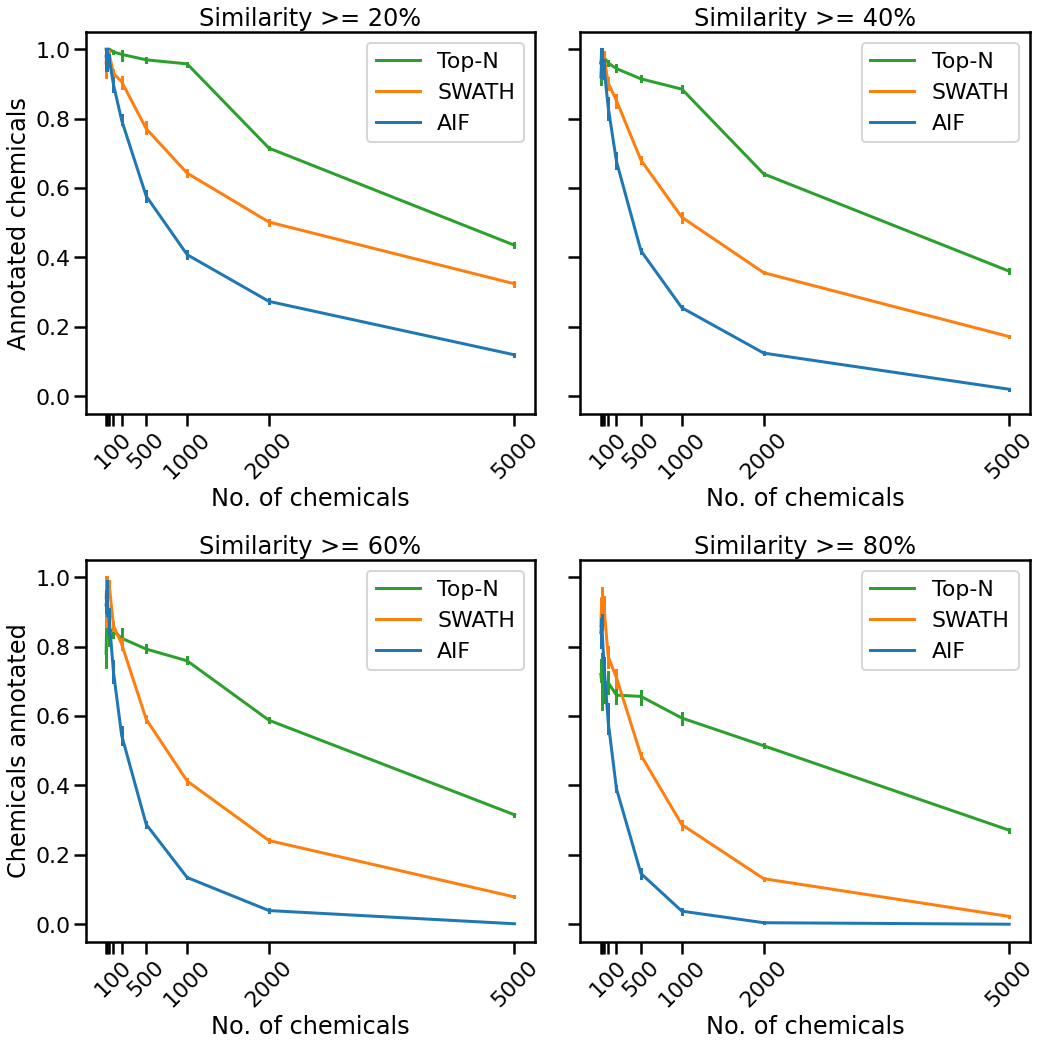

In [15]:
out_file = os.path.join(output_folder, 'spectral_comparison.png')
plot_hit_proportion(cvc_df, out_file=out_file)

In [16]:
cvc_df.head()

,method,matching_threshold,no_annotated_compounds,no_annotated_peaks,prop_annotated_compounds,prop_annotated_peaks,annotated_peaks,num_chem,repeat
0,topN,0.0,10,10,1.0,1.0,"{peak_917.853168, peak_951.873903, peak_477.10...",10,0
1,topN,0.1,10,10,1.0,1.0,"{peak_917.853168, peak_951.873903, peak_477.10...",10,0
2,topN,0.2,10,10,1.0,1.0,"{peak_917.853168, peak_951.873903, peak_477.10...",10,0
3,topN,0.3,10,10,1.0,1.0,"{peak_917.853168, peak_951.873903, peak_477.10...",10,0
4,topN,0.4,9,9,0.9,0.9,"{peak_951.873903, peak_477.102753, peak_961.82...",10,0


In [17]:
filtered_df = cvc_df.loc[(cvc_df['matching_threshold'] == 0.6) & (cvc_df['num_chem'] == 100)]
filtered_df.groupby('method')['prop_annotated_compounds'].mean()

method
AIF      0.726
SWATH    0.860
topN     0.844
Name: prop_annotated_compounds, dtype: float64

In [18]:
filtered_df = cvc_df.loc[(cvc_df['matching_threshold'] == 0.6) & (cvc_df['num_chem'] == 200)]
filtered_df.groupby('method')['prop_annotated_compounds'].mean()

method
AIF      0.544
SWATH    0.807
topN     0.824
Name: prop_annotated_compounds, dtype: float64

In [19]:
filtered_df = cvc_df.loc[(cvc_df['matching_threshold'] == 0.6) & (cvc_df['num_chem'] == 500)]
filtered_df.groupby('method')['prop_annotated_compounds'].mean()

method
AIF      0.2876
SWATH    0.5904
topN     0.7928
Name: prop_annotated_compounds, dtype: float64

In [20]:
filtered_df = cvc_df.loc[(cvc_df['matching_threshold'] == 0.6) & (cvc_df['num_chem'] == 5000)]
filtered_df.groupby('method')['prop_annotated_compounds'].mean()

method
AIF      0.00128
SWATH    0.07860
topN     0.31532
Name: prop_annotated_compounds, dtype: float64

# 2. Plot Distribution of spectral similarity scores

In [21]:
num_chems, repeat

([10, 20, 50, 100, 200, 500, 1000, 2000, 5000], 5)

In [22]:
num_chems = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
repeat = 1

In [23]:
pickle_file = os.path.join(output_folder, 'score_df.p')
if not exists(pickle_file):
    score_df = spectral_distribution_simulated(base_folder, msp_folder, suffix, methods, num_chems, repeat, matching_threshold, 
                                     matching_method, matching_ms1_tol, matching_ms2_tol, matching_min_match_peaks, keep_all=False)  
    score_df.to_pickle(pickle_file)
score_df = pd.read_pickle(pickle_file)

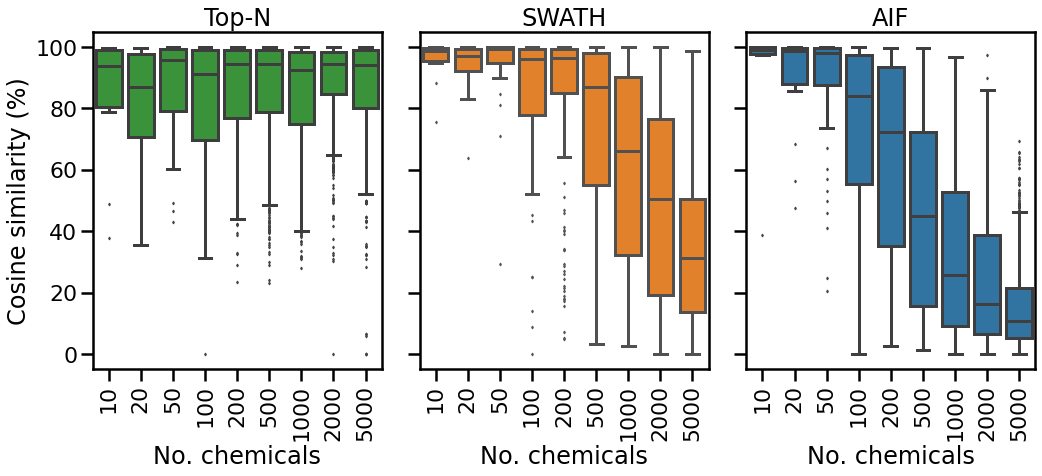

In [24]:
out_file = os.path.join(output_folder, 'score_distribution.png')
palette = plot_score_distribution_simulated(score_df, out_file=out_file)

### Example using 5000 chemicals

In [25]:
temp_num_chems = [5000]
temp_repeat = 1

In [26]:
temp_score_df = spectral_distribution_simulated(base_folder, msp_folder, suffix, methods, temp_num_chems, temp_repeat, matching_threshold, 
                                 matching_method, matching_ms1_tol, matching_ms2_tol, matching_min_match_peaks, keep_all=False)  

5000 0


In [27]:
temp_score_df['score_percent'] = temp_score_df['score'] * 100
temp_score_df.head()

,method,fullscan_peak,matched_id,score,num_chem,repeat,score_percent
0,topN,peak_793.727967,KnowChemical_C50H96O6_iso0_num0\n,0.942034,5000,0,94.203423
1,topN,peak_869.795653,KnowChemical_C57H88O6_iso0_num1885\n,0.993382,5000,0,99.338221
2,topN,peak_903.743617,KnowChemical_C59H98O6_iso0_num5\n,0.986293,5000,0,98.629316
3,topN,peak_695.618417,KnowChemical_C43H82O6_iso0_num6\n,0.996533,5000,0,99.653283
4,topN,peak_751.681017,KnowChemical_C47H90O6_iso0_num47\n,0.953494,5000,0,95.349355


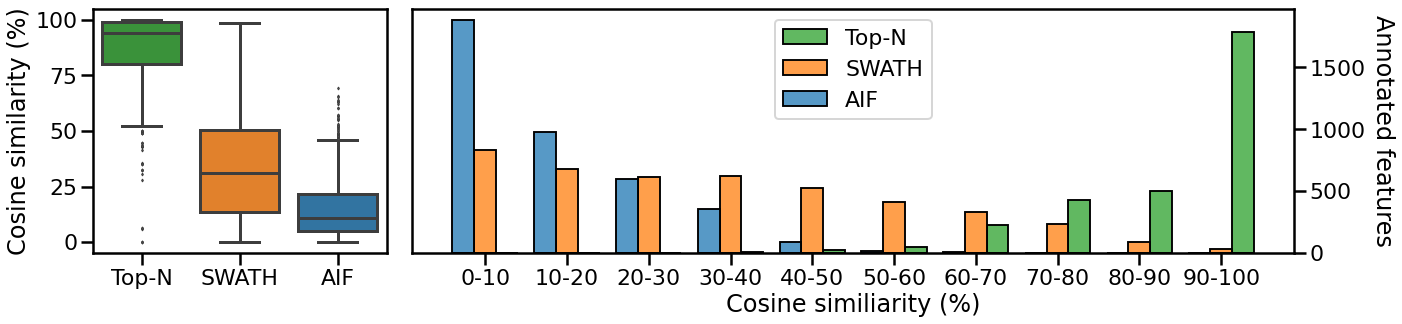

In [28]:
out_file = os.path.join(output_folder, 'score_distribution_5000.png')
_ = plot_score_distributions(temp_score_df, bins=10, out_file=out_file)

In [29]:
temp_score_df.groupby(['method'])['score_percent'].median()

method
AIF      10.737792
SWATH    31.307906
topN     94.087157
Name: score_percent, dtype: float64

### Check self-similarity

In [30]:
num_chems, repeat

([10, 20, 50, 100, 200, 500, 1000, 2000, 5000], 1)

In [31]:
num_chems = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
repeat = 1

In [32]:
pickle_file = os.path.join(output_folder, 'pairwise_score_df.p')
if not exists(pickle_file):
    pairwise_score_df = pairwise_spectral_distribution_simulated(
            base_folder, msp_folder, num_chems, repeat, suffix,
            methods, matching_threshold, matching_method, matching_ms1_tol,
            matching_ms2_tol, matching_min_match_peaks)
    save_obj(pairwise_score_df, pickle_file)
pairwise_score_df = load_obj(pickle_file)

In [33]:
def plot_pairwise_score_distribution(plot_df, suptitle=None, out_file=None, palette=None):    
    fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

    if palette is None:
        palette = get_palette(plot_df)

    plot_df['score_percent'] = plot_df['score'] * 100        
        
    df = plot_df[plot_df['method'] == 'ground_truth'].copy()
    axes = ax[0][0]
    sns.boxplot(data=df, x='num_chem', y='score_percent', ax=axes, flierprops = dict(markerfacecolor = '0.50', markersize = 2), color='white')    
    axes.set_title('Ground Truth')
    axes.set_ylabel('Cosine similarity (%)')    
    axes.set_xlabel(None)
    axes.set_ylim((-1, 25))

    df = plot_df[plot_df['method'] == 'topN'].copy()
    axes = ax[0][1]    
    sns.boxplot(data=df, x='num_chem', y='score_percent', ax=axes, flierprops = dict(markerfacecolor = '0.50', markersize = 2), color=palette['topN'])    
    axes.set_title('Top-N')
    axes.set_ylabel(None)    
    axes.set_xlabel(None)

    df = plot_df[plot_df['method'] == 'SWATH'].copy()
    axes = ax[1][0]        
    sns.boxplot(data=df, x='num_chem', y='score_percent', ax=axes, flierprops = dict(markerfacecolor = '0.50', markersize = 2), color=palette['SWATH'])    
    axes.set_title('SWATH')
    axes.set_ylabel('Cosine similarity (%)')    
    axes.set_xlabel('No. chemicals')
    axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

    df = plot_df[plot_df['method'] == 'AIF'].copy()
    axes = ax[1][1]        
    g = sns.boxplot(data=df, x='num_chem', y='score_percent', ax=axes, flierprops = dict(markerfacecolor = '0.50', markersize = 2), color=palette['AIF'])    
    axes.set_title('AIF')
    axes.set_xlabel('No. chemicals')
    axes.set_ylabel(None)
    axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
        
    # g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)    
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
    
    plt.suptitle(suptitle, fontsize=36)
    plt.tight_layout()
    
    if out_file is not None:
        plt.savefig(out_file, dpi=300, bbox_inches="tight")

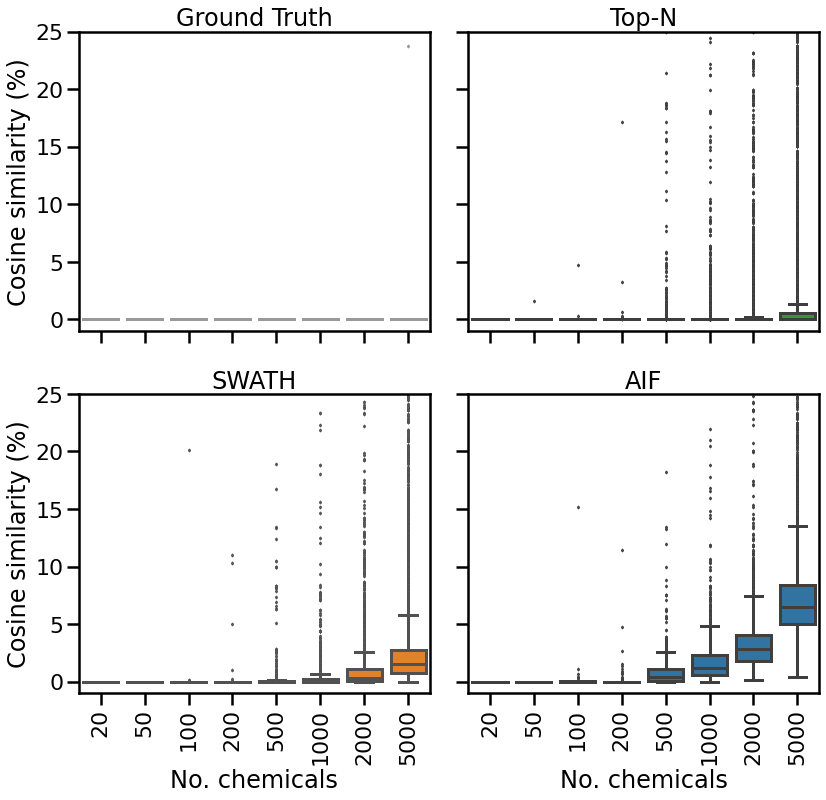

In [34]:
out_file = os.path.join(output_folder, 'pairwise_similarity.png')
plot_pairwise_score_distribution(pairwise_score_df, palette=palette, out_file=out_file)